In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from IPython import display

import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")

# don't need labels!
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

In [ ]:
# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 150)

            ### encoder layer
            self.enc = nn.Linear(150, 15)

            ### latent layer
            self.lat = nn.Linear(15, 150)

            ### decoder layer
            self.dec = nn.Linear(150, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            encx = F.relu(self.enc(x))
            x = F.relu(self.lat(encx))
            y = torch.sigmoid(self.dec(x))
            return y,encx

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [4]:
# test the model with a bit of data
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


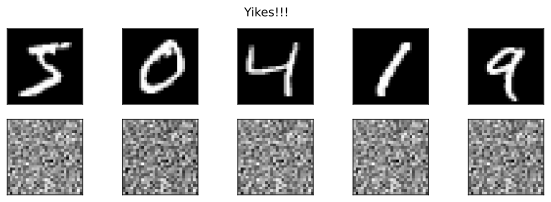

In [5]:
# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(yHat[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle("Yikes!!!")
plt.show()

In [6]:
def function2trainTheModel():

    # number of epochs
    numepochs = 10000

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE()

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx, :]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.cpu().item()
    # end epochs

    # function output
    return losses, net

Final loss: 0.0071


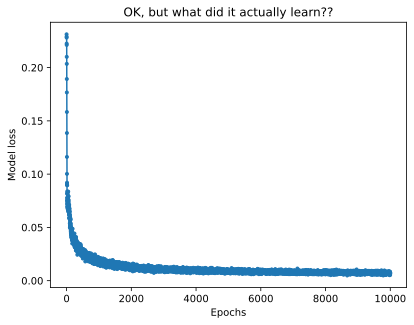

In [7]:
# train the model (90s)
losses, net = function2trainTheModel()
print(f"Final loss: {losses[-1]:.4f}")

# visualize the losses
plt.plot(losses.cpu(), ".-")
plt.xlabel("Epochs")
plt.ylabel("Model loss")
plt.title("OK, but what did it actually learn??")
plt.show()

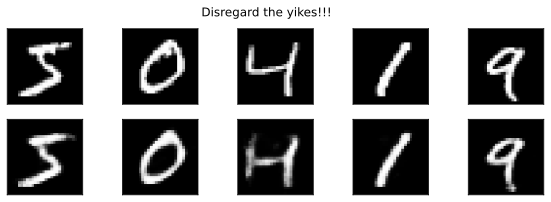

In [8]:
# Repeat the visualization when testing the model
X = dataT[:5, :]
yHat = net(X)


# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(yHat[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle("Disregard the yikes!!!")
plt.show()

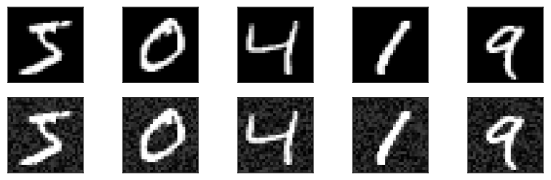

In [9]:
# Add the noise and now see the magic
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 4

# clip at 1
Xnoise[Xnoise > 1] = 1


# show the noisy images
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

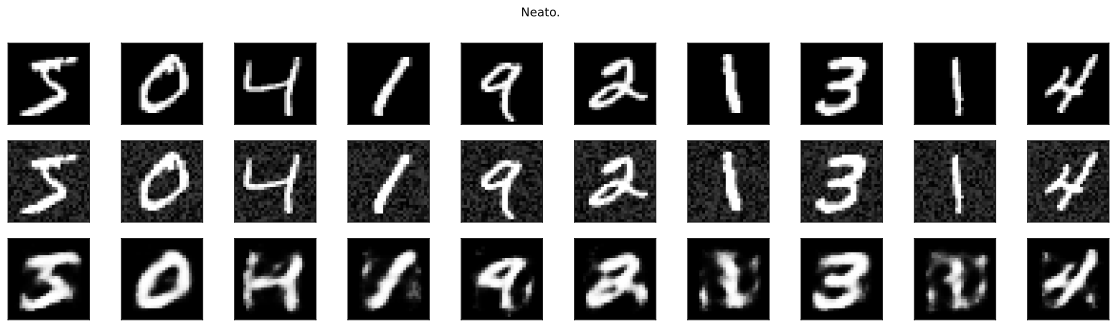

In [10]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[2, i].imshow(Y[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle("Neato.")
plt.show()

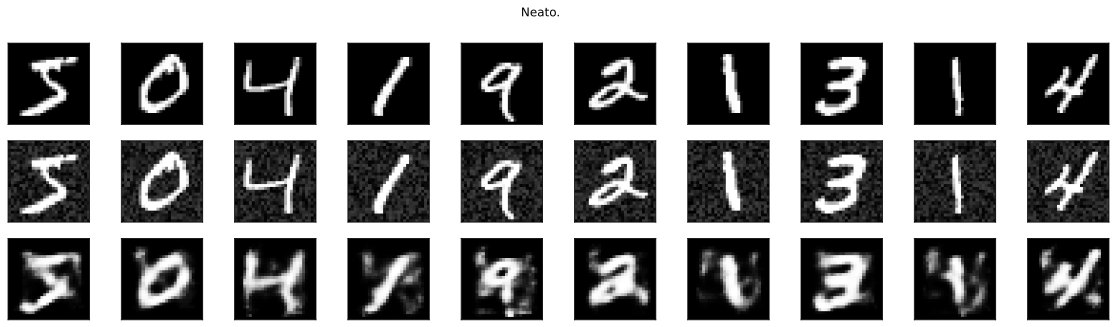

In [ ]:
# 1) Because these are continuous data, mean-squared-error is the correct loss function. But I mentioned in the previous
#    video that binary cross-entropy loss is *sometimes* used in autoencoders. Does the loss function make a difference
#    for this problem? Why?
# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 250)

            ### encoder layer
            self.enc = nn.Linear(250, 50)

            ### latent layer
            self.lat = nn.Linear(50, 250)

            ### decoder layer
            self.dec = nn.Linear(250, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.BCELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer


# Model instance
net, lossfun, optimizer = createTheMNISTAE()
# Train the Model
losses, net = function2trainTheModel()

# Add the noise and now see the magic
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 4

# clip at 1
Xnoise[Xnoise > 1] = 1
# run through the model
Y = net(Xnoise)


# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[2, i].imshow(Y[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle("Neato.")
plt.show()

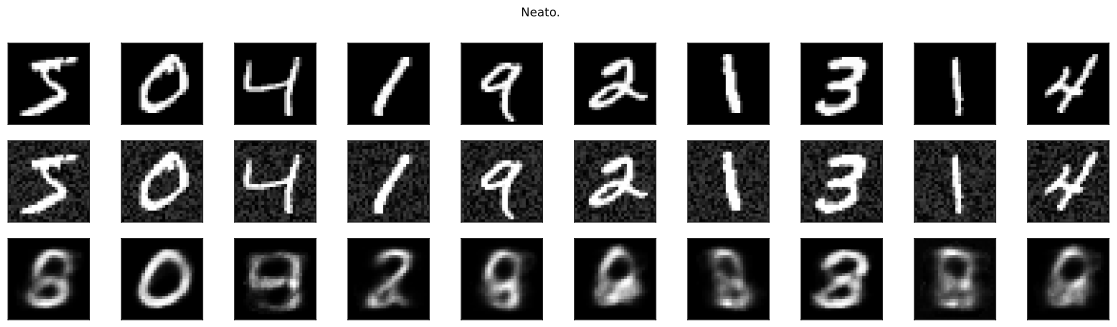

In [15]:
# 2) Change the number of units in the latent layer to 10. How does that affect the loss and denoising? Don't turn this
#    into a full parametric experiment -- that's for the next video!


# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 250)

            ### encoder layer
            self.enc = nn.Linear(250, 10)

            ### latent layer
            self.lat = nn.Linear(10, 250)

            ### decoder layer
            self.dec = nn.Linear(250, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer


# Model instance
net, lossfun, optimizer = createTheMNISTAE()
# Train the Model
losses, net = function2trainTheModel()

# Add the noise and now see the magic
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 4

# clip at 1
Xnoise[Xnoise > 1] = 1
# run through the model
Y = net(Xnoise)


# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[2, i].imshow(Y[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle("Neato.")
plt.show()

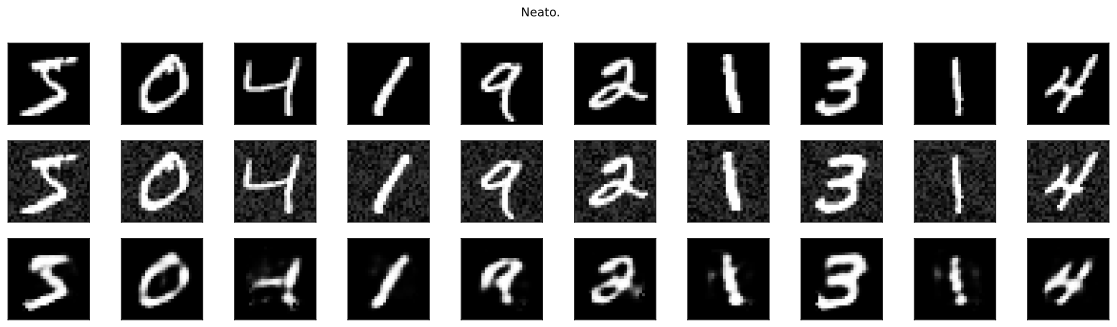

In [ ]:
# 3) The code here picks samples randomly, which means many samples are skipped, and some could be repeated. Change the
#    code so that the model goes through every item exactly once per epoch. The order should be randomized to avoid
#    possible order effects. You'll probably want to reduce the number of epochs!


# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 250)

            ### encoder layer
            self.enc = nn.Linear(250, 50)

            ### latent layer
            self.lat = nn.Linear(50, 250)

            ### decoder layer
            self.dec = nn.Linear(250, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

# Function to train the model
def function2trainTheModel():

    # number of epochs
    numepochs = 3000

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE()

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        randomidx = np.random.choice(dataT.shape[0], size=60000)
        X = dataT[randomidx, :]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.cpu().item()
    # end epochs

    # function output
    return losses, net


# Model instance
net, lossfun, optimizer = createTheMNISTAE()
# Train the Model
losses, net = function2trainTheModel()

# Add the noise and now see the magic
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 4

# clip at 1
Xnoise[Xnoise > 1] = 1
# run through the model
Y = net(Xnoise)


# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[2, i].imshow(Y[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle("Neato.")
plt.show()

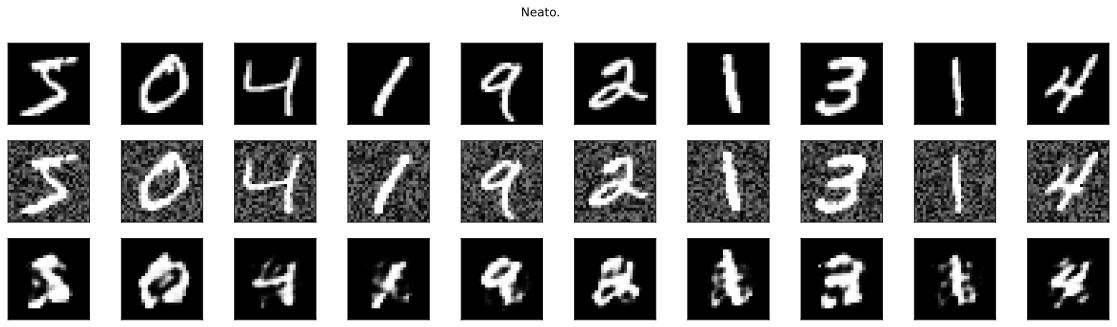

In [25]:
# 4) The autoencoder did a pretty decent job at denoising the images. How far can you push this? Try adding more noise
#    to the images and re-running the test code (you don't need to retrain the model). Is the autoencoder robust to a
#    a larger amount of noise?

# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 512)

            ### encoder layer
            self.enc = nn.Linear(512, 128)

            ### latent layer
            self.lat = nn.Linear(128, 512)

            ### decoder layer
            self.dec = nn.Linear(512, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer


# Function to train the model
def function2trainTheModel():

    # number of epochs
    numepochs = 6000

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE()

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        randomidx = np.random.choice(dataT.shape[0], size=60000)
        X = dataT[randomidx, :]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.cpu().item()
    # end epochs

    # function output
    return losses, net


# Model instance
net, lossfun, optimizer = createTheMNISTAE()
# Train the Model
losses, net = function2trainTheModel()

# Add the noise and now see the magic
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 2

# clip at 1
Xnoise[Xnoise > 1] = 1
# run through the model
Y = net(Xnoise)


# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[2, i].imshow(Y[i, :].view(28, 28).cpu().detach(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle("Neato.")
plt.show()